## MSstatsTMT Analysis：Proteomics differential expression downstream analysis

#### The following Jupyter notebooks allows to perform differential expression data analysis from multiple pipelines developed by the bigbio team. The output of the following pipelines are supported: 

- [proteomicsTMT](https://github.com/bigbio/proteomicstmt): TMT pipeline based on OpenMS and nextflow.

For the data with isobaric labeling, using the [MSstatsTMT](https://www.bioconductor.org/packages/release/bioc/html/MSstatsTMT.html) to perform the downstream data analysis. Major steps in the data processing are the following:

- Importing data from the pipeline. The major source of data are:
  - out.mzTab
  - metadata.sdrf.tsv or experimental_design.tsv 

### Convert out.mzTab to MSstatsTMT report from OpenMS

In [1]:
from pyteomics import mztab
import pandas as pd
import re
from sdrf_pipelines.openms.openms import OpenMS


def convert(mztab_file, out_msstats, exp_design=None, sdrf=None):
    print("Generating file ........")
    mz = mztab.MzTab(mztab_file)
    pep_table = mz.peptide_table
    meta_data = mz.metadata
    OutDataFrame = list()
    tech_map = dict()
    if sdrf:
        OpenMS.openms_convert(sdrf)
        exp_design = './experimental_design.tsv'

    with open(exp_design, 'r') as f:
        data = f.readlines()
        empty_row = data.index('\n')
        f_table = [i.replace('\n', '').split('\t') for i in data[1:empty_row]]
        f_table = pd.DataFrame(f_table)
        s_table = [i.replace('\n', '').split('\t') for i in data[data.index('\n') + 1:]][1:]
        s_header = data[data.index('\n') + 1].replace('\n', '').split('\t')
        s_DataFrame = pd.DataFrame(s_table, columns=s_header)

    for _, row in f_table.iterrows():
        mix = s_DataFrame[s_DataFrame['Sample'] == row[4]]['MSstats_Mixture'].values[0]
        if mix in tech_map:
            if row[2] not in tech_map[mix]:
                tech_map[mix].append(row[2])
        else:
            tech_map[mix] = [row[2]]

    for _, row in pep_table.iterrows():
        
        # remove the decoy
        if row['opt_global_cv_MS:1002217_decoy_peptide'] == 1 or 'DECOY' in row['accession']:
            continue
        spectra_ref = meta_data[row['spectra_ref'].split(':')[0] + '-location'].replace("file://", '')
        channels = f_table[f_table[2] == spectra_ref][3].tolist()  # assume order
        fraction = f_table[f_table[2] == spectra_ref][1].tolist()[0]
        run = row['spectra_ref'].split(':')[0]
        index = int(re.search(r'(\d+)', row['spectra_ref'].split(':')[0]).group(1))
        b = 1
        for channel in channels:
            sample = f_table[(f_table[2] == spectra_ref) & (f_table[3] == channel)][4].tolist()[0]
            position = s_DataFrame[s_DataFrame['Sample'] == sample]
            mixture = position['MSstats_Mixture'].values[0]
            TechRepMixture = str(mixture) + '_' + str(tech_map[mixture].index(spectra_ref) + 1)
            condition = position['MSstats_Condition'].values[0]
            
            # set the condition of reference channel as Norm so that nomorlization
            if channel == '10':
                condition = 'Norm'
            
            BioReplicate = position['MSstats_BioReplicate'].values[0]
            intensity = row['peptide_abundance_study_variable[' + str(len(channels) * (index - 1) + b) + ']']
            b += 1
            OutDataFrame.append({'RetentionTime': row['retention_time'], 'ProteinName': row['accession'],
                                 'PeptideSequence': row['opt_global_cv_MS:1000889_peptidoform_sequence'],
                                 'Charge': row['charge'], 'Channel': channel, 'Condition': condition,
                                 'BioReplicate': BioReplicate, 'Run': run, 'Mixture': mixture,
                                 'TechRepMixture': TechRepMixture, 'Fraction': fraction,
                                 'Intensity': intensity, 'Reference': spectra_ref})

    d = pd.DataFrame(OutDataFrame, columns=['RetentionTime', 'ProteinName', 'PeptideSequence', 'Charge',
                                            'Channel', 'Condition', 'BioReplicate', 'Run', 'Mixture',
                                            'TechRepMixture', 'Fraction', 'Intensity', 'Reference'])
    
    d.to_csv(out_msstats, sep='\t', header=True, index=False)

if __name__ == '__main__':
    convert("../include_top/out.mzTab",
            '../include_top/out_msstats_norm.csv',
            exp_design='../include_top/experimental_design.tsv'
            )

Generating file ........


In [1]:
%load_ext rpy2.ipython

C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  "The symbol '%s' is not in this R namespace/package." % name


In [2]:
%%R -w 800 -h 600

library('MSstatsTMT', warn.conflicts = F, quietly = T, verbose = F)
data_folder = 'C:/Users/ChengXin/MyProgram/TMTProjects/PXD014414/include_top'
setwd(data_folder)
openms_output = './out_msstats_norm.csv'

raw.om <- read.csv(openms_output, header = TRUE, sep = '\t')
input.om <- OpenMStoMSstatsTMTFormat(raw.om)
head(input.om)

INFO  [2021-08-04 15:22:42] ** Raw data from OpenMS imported successfully.
INFO  [2021-08-04 15:22:43] ** Raw data from OpenMS cleaned successfully.
INFO  [2021-08-04 15:22:43] ** The following options are used:
  - Features will be defined by the columns: PeptideSequence, PrecursorCharge
  - Shared peptides will be removed.
  - Proteins with single feature will not be removed.
  - Features with less than 3 measurements within each run will be removed.
INFO  [2021-08-04 15:22:44] ** Features with all missing measurements across channels within each run are removed.
INFO  [2021-08-04 15:22:44] ** Shared peptides are removed.
INFO  [2021-08-04 15:22:44] ** Features with one or two measurements across channels within each run are removed.
INFO  [2021-08-04 15:22:50] ** PSMs have been aggregated to peptide ions.
INFO  [2021-08-04 15:22:52] ** Fractions belonging to same mixture have been combined.
INFO  [2021-08-04 15:22:52] ** Features with one or two measurements across channels within e

### Protein summarization, normalization and visualization

In [3]:
%%R -w 1000 -h 600

protein_expression = './protein_expression.csv'

# use MSstatsTMT for protein summarization
quant_om.msstats <- proteinSummarization(input.om,
                                      method="msstats",
                                      global_norm=TRUE,
                                      reference_norm=TRUE,
                                      remove_norm_channel = TRUE,
                                      remove_empty_channel = TRUE)

## Profile plot without norm channnels and empty channels
dataProcessPlotsTMT(data=quant_om.msstats,
                     type = 'ProfilePlot',
                     which.Protein = 'sp|P04406|G3P_HUMAN',
                     width = 25, # adjust the figure width 
                     height = 12,
                     address='./')
TMTProtein.Expression <- quant_om.msstats$ProteinLevelData[, c('Protein', 'Abundance', 'Condition')]

write.csv(TMTProtein.Expression, file=protein_expression, row.names=FALSE)

INFO  [2021-08-04 15:26:01] ** MSstatsTMT - proteinSummarization function
INFO  [2021-08-04 15:26:01] Summarizing for Run : 2_2_1 ( 1  of  24 )
  |======================================================================| 100%
INFO  [2021-08-04 15:26:05] Summarizing for Run : 1_1_1 ( 2  of  24 )
  |======================================================================| 100%
INFO  [2021-08-04 15:26:09] Summarizing for Run : 3_3_8 ( 3  of  24 )
  |======================================================================| 100%
INFO  [2021-08-04 15:26:15] Summarizing for Run : 2_2_8 ( 4  of  24 )
  |======================================================================| 100%
INFO  [2021-08-04 15:26:21] Summarizing for Run : 3_3_1 ( 5  of  24 )
  |======================================================================| 100%
INFO  [2021-08-04 15:26:25] Summarizing for Run : 2_2_5 ( 6  of  24 )
  |======================================================================| 100%
INFO  [2021-08-04 15:26:29

R[write to console]: Drew the Profile plot for 1 proteins.



  |======================================================================| 100%


R[write to console]: Drew the Profile plot with summarization for 1 proteins.



  |======================================================================| 100%


In [4]:
%%R -w 1000 -h 600

tmp <- levels(input.om$ProteinName)
selector <- append('allonly', tmp, 1)
## Quality control plot 
dataProcessPlotsTMT(data=quant_om.msstats, 
                     type='QCPlot',
                     which.Protein=selector,
                     width = 25, # adjust the figure width
                     height = 12,
                     address = './')

R[write to console]: Drew the Quality Contol plot(boxplot) over all proteins.



png 
  2 


### Tests for significant changes in protein abundance across conditions

In [5]:
%%R
# Check the conditions in the protein level data
levels(quant_om.msstats$ProteinLevelData$Condition)

[1] "metaplastic breast carcinomas|Chondroid"      
[2] "metaplastic breast carcinomas|Spindle"        
[3] "metaplastic breast carcinomas|Squamous"       
[4] "Normal|Normal breast"                         
[5] "Triple-negative breast cancer|Triple-negative"


In [50]:
%%R -w 1000 -h 600

Cancer_Normal_Comp<-matrix(c(0,0,1,0,1,0,0,0,0,1,0,0,-1,-1,-1,-1,0,0,0,1),nrow=4)
row.names(Cancer_Normal_Comp)<-c("MBC Spindle vs Normal", "MBC Squamous vs Normal", "MBC Sarcomatoid vs Normal", "TNBC vs Normal")
colnames(Cancer_Normal_Comp) = c("metaplastic breast carcinomas|Chondroid","metaplastic breast carcinomas|Spindle",
                        "metaplastic breast carcinomas|Squamous","Normal|Normal breast","Triple-negative breast cancer|Triple-negative")


Cancer_Normal_Comp.pairwise <- groupComparisonTMT(quant_om.msstats, contrast.matrix = Cancer_Normal_Comp, moderated = TRUE)

INFO  [2021-08-04 20:01:52] Model fitting for 2876 proteins.
  |======================================================================| 100%
INFO  [2021-08-04 20:04:33] Testing for 2876 proteins:
  |======================================================================| 100%


In [52]:
%%R

head(Cancer_Normal_Comp.pairwise$ComparisonResult)

                     Protein                     Label    log2FC        SE
1:  sp|A0A075B6H7|KV37_HUMAN     MBC Spindle vs Normal -3.260538 1.4511008
2:  sp|A0A075B6H7|KV37_HUMAN    MBC Squamous vs Normal -1.387271 1.1848188
3:  sp|A0A075B6H7|KV37_HUMAN MBC Sarcomatoid vs Normal -3.367490 1.1848188
4:  sp|A0A075B6H7|KV37_HUMAN            TNBC vs Normal -2.544472 1.1848188
5: sp|A0A075B6P5|KV228_HUMAN     MBC Spindle vs Normal -1.484713 0.5845290
6: sp|A0A075B6P5|KV228_HUMAN    MBC Squamous vs Normal -0.687955 0.6544614
          DF     pvalue adj.pvalue issue
1:  9.499555 0.04976818  0.1765576  <NA>
2:  9.499555 0.27018297  0.5277451  <NA>
3:  9.499555 0.01835182  0.2702810  <NA>
4:  9.499555 0.05870819  0.1803307  <NA>
5: 27.745829 0.01697465  0.0920287  <NA>
6: 27.877299 0.30220440  0.5538752  <NA>


#### Visualization Cancer vs Normal Condition (Supplementary figure3 B)

In [53]:
%%R

Cancer_Normal_Comp = Cancer_Normal_Comp.pairwise$ComparisonResult
write.table(Cancer_Normal_Comp,"Cancer_Normal_Comp_result.csv",row.names=FALSE,col.names=TRUE,sep=",")

In [54]:
# map protein to gene name
import re
import urllib.parse
import urllib.request

def MapProtGeneName(prots):
    url = 'https://www.uniprot.org/uploadlists/'
    query = ' '.join(prots)
    params = {
    'from': 'ACC+ID',
    'to': 'GENENAME',
    'format': 'tab',
    'query':query
    }

    data = urllib.parse.urlencode(params)
    data = data.encode('utf-8')
    req = urllib.request.Request(url, data)
    with urllib.request.urlopen(req) as f:
        response = f.read()
        data = response.decode('utf-8')
        return re.split('\t|\n', data)[3::2]


                     Protein                      Label    log2FC    pvalue  \
0   sp|A0A075B6H7|KV37_HUMAN      MBC Spindle vs Normal -3.260538  0.049768   
1   sp|A0A075B6H7|KV37_HUMAN     MBC Squamous vs Normal -1.387271  0.270183   
2   sp|A0A075B6H7|KV37_HUMAN  MBC Sarcomatoid vs Normal -3.367490  0.018352   
3   sp|A0A075B6H7|KV37_HUMAN             TNBC vs Normal -2.544472  0.058708   
4  sp|A0A075B6P5|KV228_HUMAN      MBC Spindle vs Normal -1.484713  0.016975   

   -Log10(p-value)     group  
0         1.303048  tab:blue  
1         0.568342   dimgrey  
2         1.736321  tab:blue  
3         1.231301   dimgrey  
4         1.770199  tab:blue  


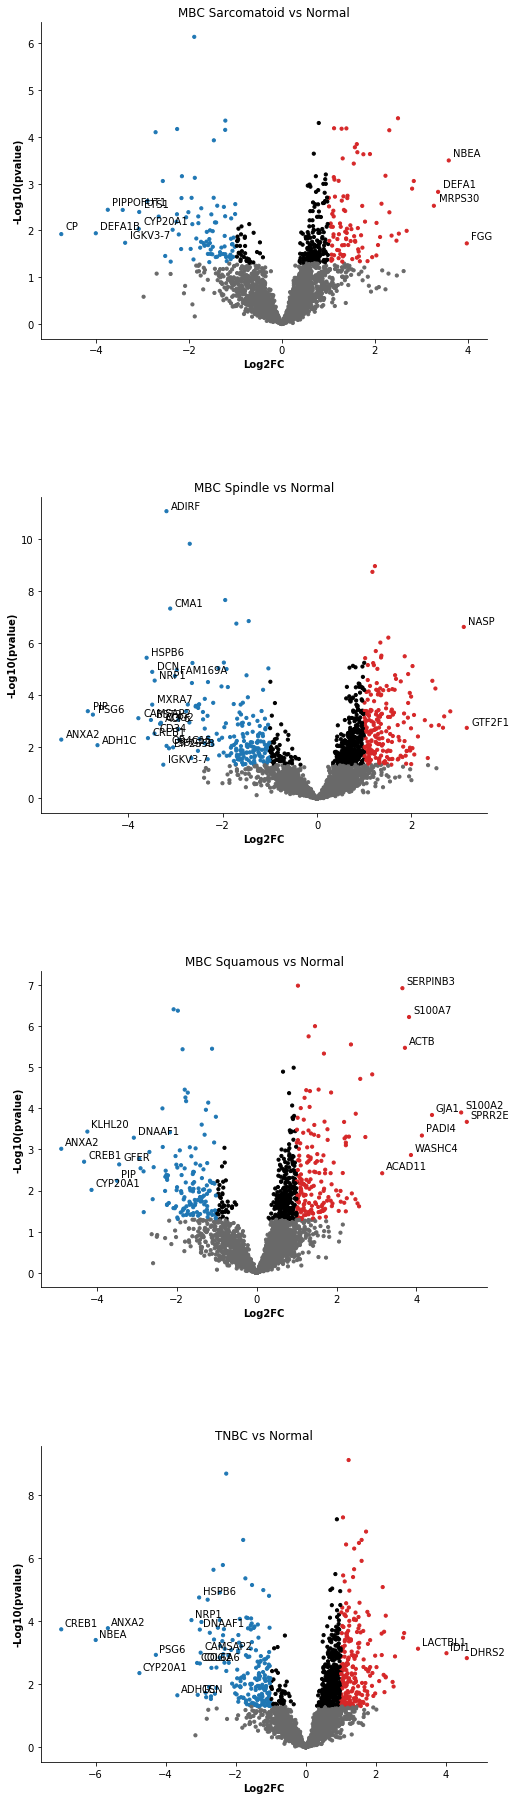

In [109]:
import pandas as pd
import seaborn as sns
import numpy as np 
from matplotlib import pyplot as plt

result = pd.read_csv('./Cancer_Normal_Comp_result.csv', sep=',')
result = result[['Protein', 'Label', 'log2FC', 'pvalue']].dropna()
result["-Log10(p-value)"] = -np.log10(result['pvalue'])

#分组为up, normal, down
result['group'] = 'black'
result.loc[(result['log2FC'] > 1)&(result['pvalue'] < 0.05),'group'] = 'tab:red' 
result.loc[(result['log2FC'] < -1)&(result['pvalue'] < 0.05),'group'] = 'tab:blue'
result.loc[result['pvalue'] >= 0.05,'group'] = 'dimgrey'
print(result.head())

xmin=-2
xmax=2
ymin=-2
ymax=10
fig = plt.figure(figsize=(8, 32))
i = 1
for comp in np.unique(result['Label']):
    data = result[result['Label'] == comp]
    ax = fig.add_subplot(410 + i)
#     ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), title='')
    ax.scatter(data['log2FC'], data["-Log10(p-value)"], s=10, c=data['group'])
    ax.set_ylabel('-Log10(pvalue)',fontweight='bold')
    ax.set_xlabel('Log2FC',fontweight='bold')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
    
#     ax.vlines(-1, ymin, ymax, color='dimgrey',linestyle='dashed', linewidth=1) 
#     ax.vlines(1, ymin, ymax, color='dimgrey',linestyle='dashed', linewidth=1) 
#     ax.hlines(-np.log10(0.05), xmin, xmax, color='dimgrey',linestyle='dashed', linewidth=1)

#     ax.set_xticks(range(-2,2,1)) 
#     ax.set_yticks(range(-2,10,3)) 
    ax.set_title(comp)
    i += 1
    
    g = MapProtGeneName(list(map(preprocess, data[(data['group'] != 'dimgrey')&(np.abs(data['log2FC']) > 3)]['Protein'].tolist())))
    j = 0
    for _,row in data[(data['group'] != 'dimgrey')&(np.abs(data['log2FC']) > 3)].iterrows():
        ax.annotate(g[j], xy = (row['log2FC'], row['-Log10(p-value)']), 
                    xytext = (row['log2FC']+0.1, row['-Log10(p-value)']+0.1))
        j += 1
    
plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.show()

C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


MBC Sarcomatoid vs Normal DownRegulated proteins: 85
MBC Sarcomatoid vs Normal UpRegulated proteins: 95
The top 10 most significant upRegulated proteins in MBC Sarcomatoid vs Normal : CP,POFUT1,DEFA1,DEFA1B,FGG,SNRNP27,TOMM6,CNN3,LCT,RPLP1,ZNF280D
The top 10 most significant downRegulated proteins in MBC Sarcomatoid vs Normal : APOM,LGALS7,LGALS7B,ERC2,ETS1,NBEA,IGKV3-7,MRPS30,PIP,CYP20A1,ANXA2
MBC Spindle vs Normal DownRegulated proteins: 192
MBC Spindle vs Normal UpRegulated proteins: 204


C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


The top 10 most significant upRegulated proteins in MBC Spindle vs Normal : GTF2F1,NASP,GJA1,NAB1,TLR2,ADCK1,H3C13,H3C14,H3C15,RPLP1,FASTKD2,MYLK
The top 10 most significant downRegulated proteins in MBC Spindle vs Normal : DCN,MXRA7,BST2,CREB1,HSPB6,CAMSAP2,ADH1C,PSG6,PIP,ANXA2
MBC Squamous vs Normal DownRegulated proteins: 139
MBC Squamous vs Normal UpRegulated proteins: 181


C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


The top 10 most significant upRegulated proteins in MBC Squamous vs Normal : SPRR2E,S100A2,GJA1,PADI4,WASHC4,S100A7,ACTB,SERPINB3,ACAD11,S100A8
The top 10 most significant downRegulated proteins in MBC Squamous vs Normal : CD163,APOM,GPR180,DNAAF1,GFER,PIP,CYP20A1,KLHL20,CREB1,ANXA2
TNBC vs Normal DownRegulated proteins: 195
TNBC vs Normal UpRegulated proteins: 222


C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


The top 10 most significant upRegulated proteins in TNBC vs Normal : DHRS2,IDI1,LACTBL1,SNRNP27,HSPA6,SMPDL3B,RAB5IF,NCBP1,RPLP1,IVNS1ABP
The top 10 most significant downRegulated proteins in TNBC vs Normal : HSPB6,GSN,COL6A6,NRP1,ADH1C,PSG6,CYP20A1,ANXA2,NBEA,CREB1


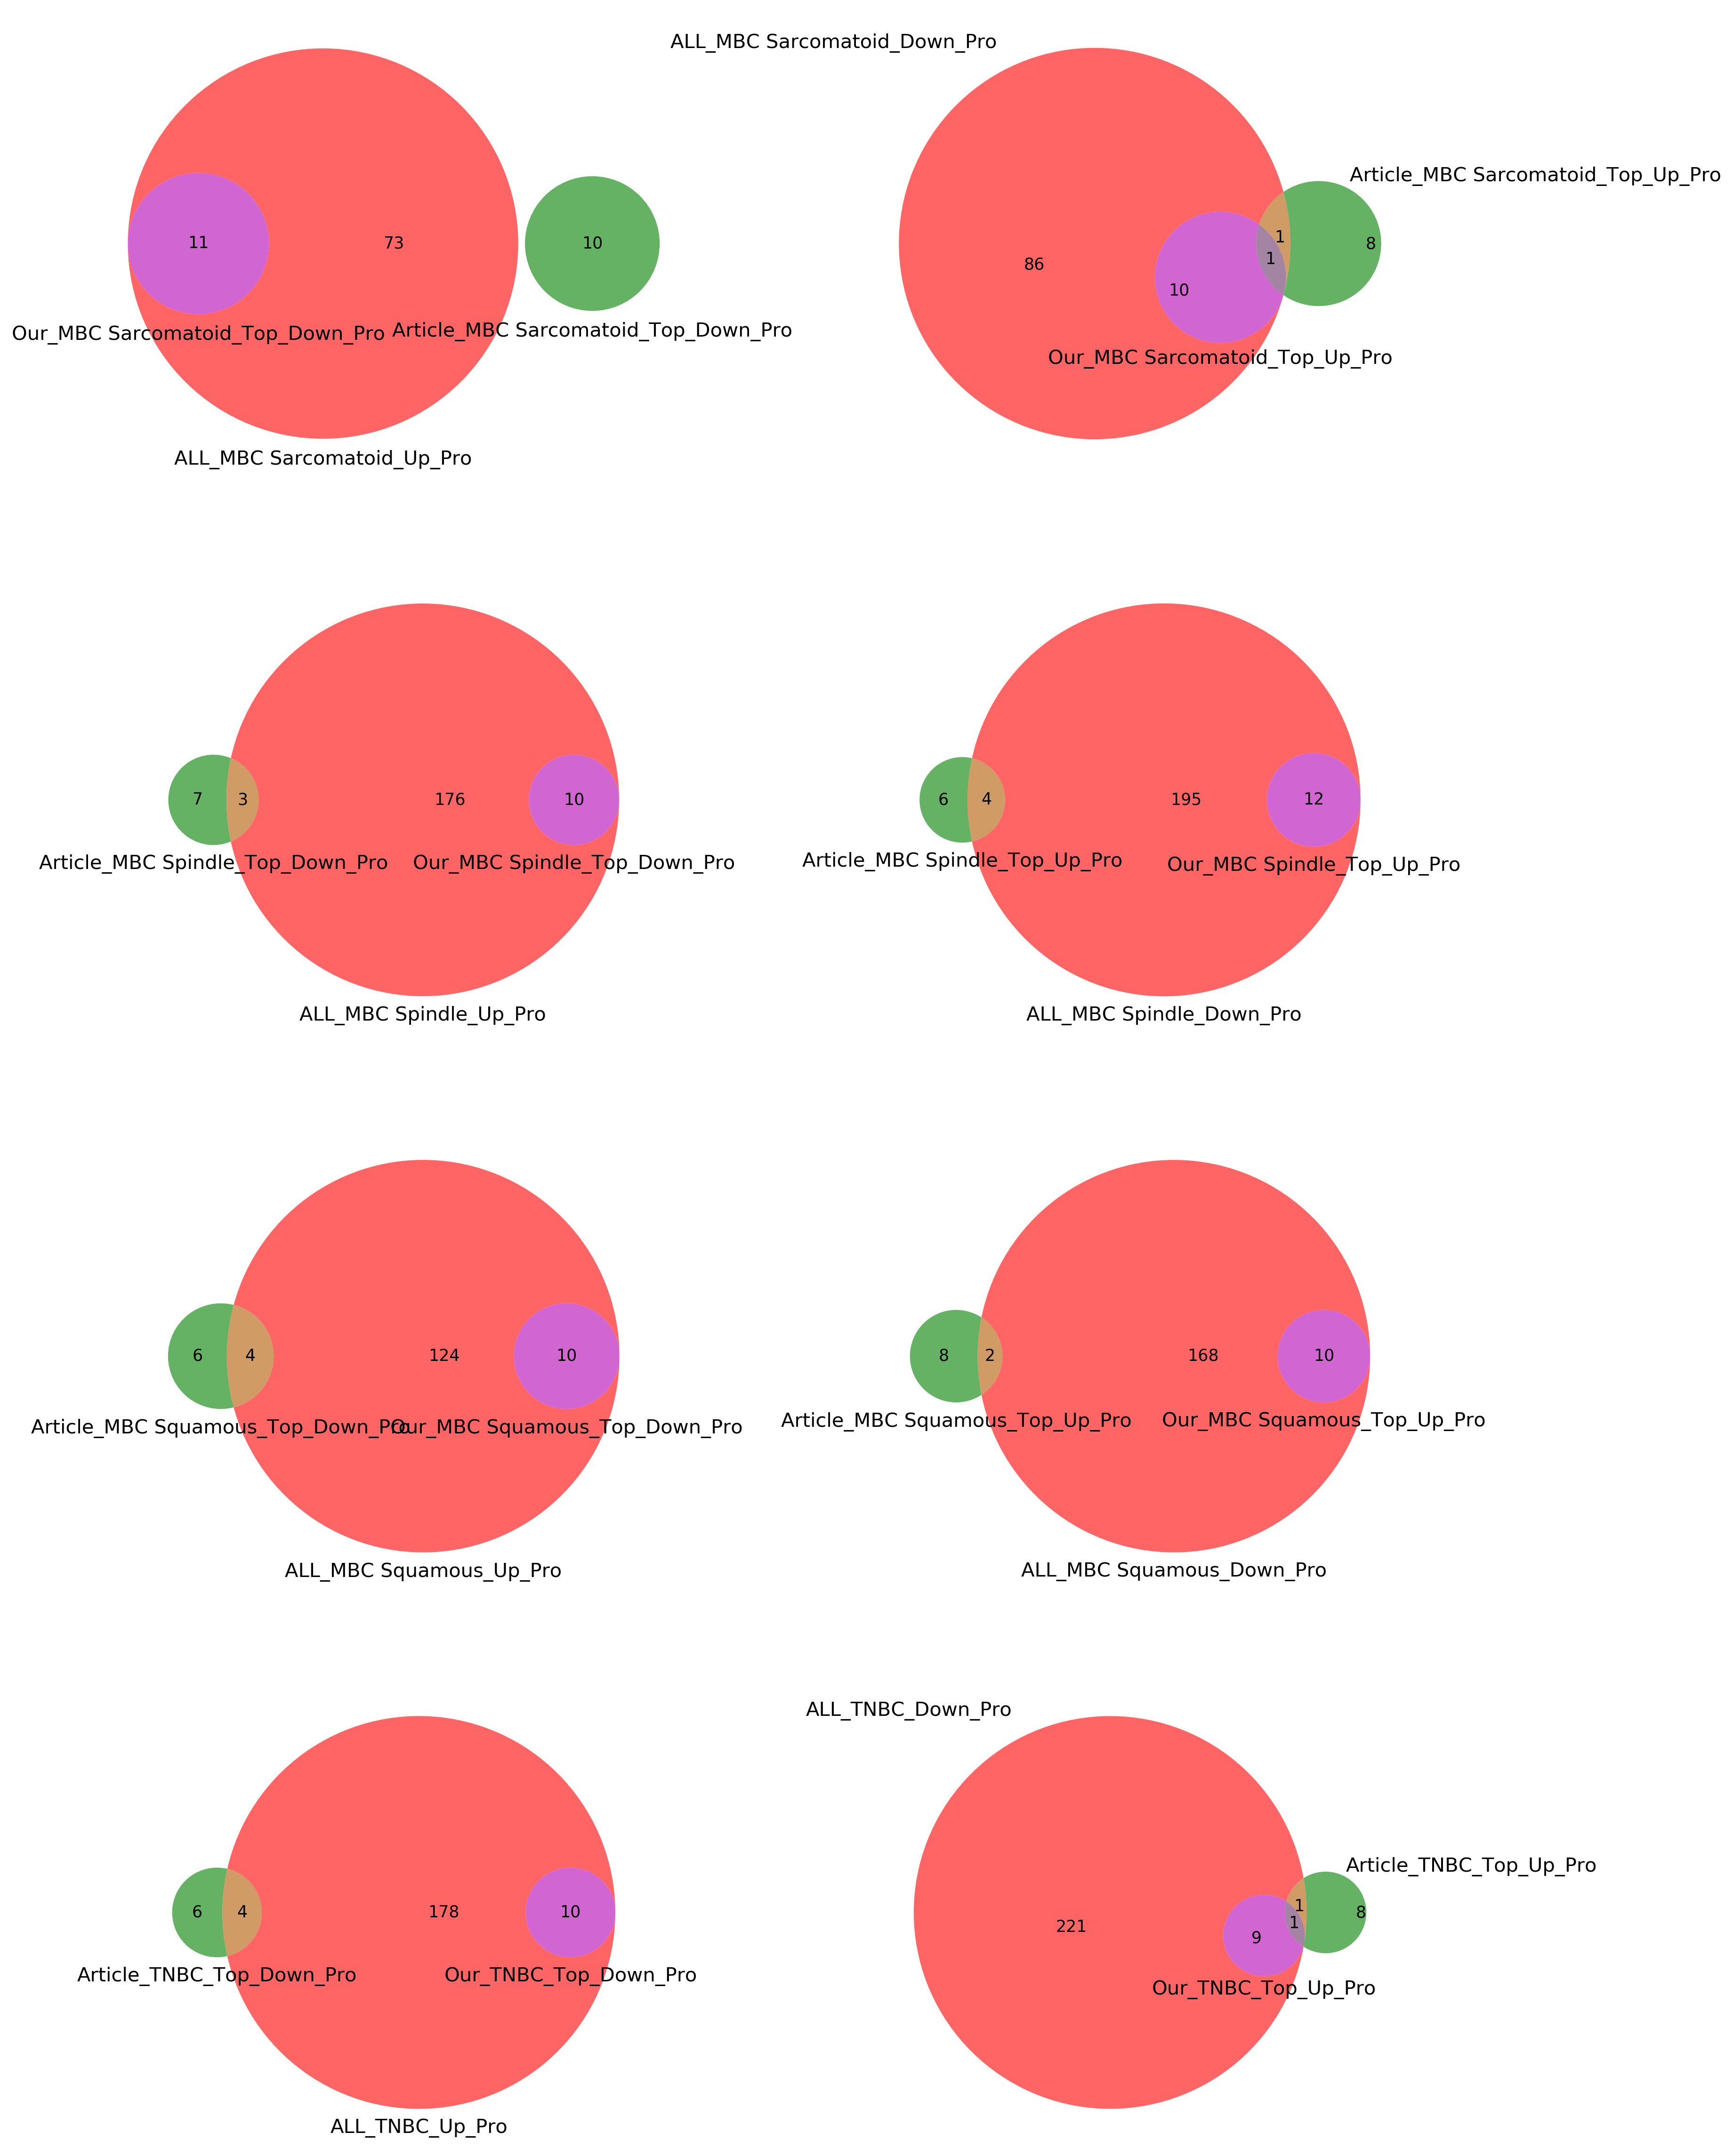

In [66]:
from matplotlib_venn import venn2, venn3
from matplotlib import pyplot as plt

result = pd.read_csv('../include_top/Cancer_Normal_Comp_result.csv', sep=',')

def preprocess(s):
    return s.split('|')[-1]

Article_Top_Up_Pro = {"TNBC vs Normal": ['HMGA1', 'RREB1', 'THBS1', 'ESPN', 'HAT1', 'APC', 'FOXP4', 'GPRC5A', 'SNRNP27', 'STMN1'],
                     "MBC Spindle vs Normal": ['RPS28', 'PLOD1', 'CALU', 'PDIA4', 'RPL28', 'CNN2', 'HIST3H2BB', 'RPL39', 'SDC2', 'MSL1'],
                     "MBC Squamous vs Normal": ['ZCCHC17', 'KRT5', 'SNUPN', 'CNN2', 'FOSL2', 'LSP1', 'SASH3', 'TMEM70', 'TLDC1', 'PAIP2'],
                     "MBC Sarcomatoid vs Normal": ['ARFGEF2', 'PCLAF', 'PTX3', 'TMEM230', 'TAF6L', 'UQCRH', 'SNRNP27', 'RREB1', 'MLLT1', 
                                                   'GOLT1B']}

Article_Top_Down_Pro = {"TNBC vs Normal": ['FCGRT', 'ADH1B', 'SHMT1', 'STAB1', 'PLTP', 'DES', 'CFD', 'IGLV211', 'IGHG1', 'TNXB'],
                       "MBC Spindle vs Normal": ['ARRDC5', 'IDO1', 'LTBP4', 'SHMT1', 'CLEC3B', 'CFD', 'CPA3', 'MYH11', 'LILRB5', 'PODN'],
                        "MBC Squamous vs Normal": ['HSPB6', 'PEX12', 'AKAP12', 'DCN', 'CFD', 'DPT', 'IGLV211', 'SERPINC1', 'MAMDC2', 'GPT'],
                       "MBC Sarcomatoid vs Normal": ['CDH5', 'FADD', 'CAP2', 'MSRA', 'GNB1', 'CD99', 'STAB1', 'KANK2', 'HNMT', 'CPM']}

fig, axs = plt.subplots(4, 2, figsize=(15,24), dpi=250)
axs = axs.flatten()
i = 0

for comp in np.unique(result['Label']):
    t = result[result["Label"] == comp]
    t_All = t['Protein'].tolist()
    t_Up = t[(t['log2FC'] > 1)&(t['pvalue'] < 0.05)]
    t_Down = t[(result['log2FC'] < -1)&(t['pvalue'] < 0.05)]
    print(comp + " DownRegulated proteins: %d" %(len(set(t_Down['Protein']))))
    print(comp + " UpRegulated proteins: %d" %(len(set(t_Up['Protein']))))

    # ALL the differential changed proteins
    ALL_t_Up_Pro  = MapProtGeneName(list(map(preprocess, t_Up['Protein'].tolist())))
    ALL_t_Down_Pro = MapProtGeneName(list(map(preprocess, t_Down['Protein'].tolist())))

    # The list of the top 10 most significant up- and downregulated proteins are given in the article.
    Article_t_Top_Down_Pro = Article_Top_Down_Pro[comp]
    Article_t_Top_Up_Pro = Article_Top_Up_Pro[comp]

    # UpRegulated proteins top 10
    Our_t_Top_Up_Pro = MapProtGeneName(list(map(preprocess, t_Up.sort_values(["log2FC"],ascending=False).head(10)['Protein'].tolist())))
    print("The top 10 most significant upRegulated proteins in " + comp + " : " + ",".join(Our_t_Top_Up_Pro))

    # top 10 downRegulated protein 
    Our_t_Top_Down_Pro = MapProtGeneName(list(map(preprocess, t_Down.sort_values(["log2FC"],ascending=False).tail(10)['Protein'].tolist())))
    print("The top 10 most significant downRegulated proteins in " + comp + " : " + ",".join(Our_t_Top_Down_Pro))

    g = venn3(subsets=[set(ALL_t_Down_Pro), set(Article_t_Top_Down_Pro), set(Our_t_Top_Down_Pro)], 
          set_labels=('ALL_' + comp.replace(" vs Normal", '') + '_Up_Pro', 'Article_' + comp.replace(" vs Normal", '') + '_Top_Down_Pro', 'Our_' 
                      + comp.replace(" vs Normal", '') + '_Top_Down_Pro'), ax=axs[i], alpha=0.6,)
    i += 1
    
    g = venn3(subsets=[set(ALL_t_Up_Pro), set(Article_t_Top_Up_Pro), set(Our_t_Top_Up_Pro)], 
          set_labels=('ALL_' + comp.replace(" vs Normal", '') + '_Down_Pro', 'Article_' + comp.replace(" vs Normal", '') + '_Top_Up_Pro', 'Our_' 
                      + comp.replace(" vs Normal", '') + '_Top_Up_Pro'), ax=axs[i], alpha=0.6,)
    i += 1

plt.show() 

TNBC DownRegulated proteins: 195
TNBC UpRegulated proteins: 222
The top 10 most significant upRegulated proteins: DHRS2,IDI1,LACTBL1,SNRNP27,HSPA6,SMPDL3B,RAB5IF,NCBP1,RPLP1,IVNS1ABP
The top 10 most significant downRegulated proteins: HSPB6,GSN,COL6A6,NRP1,ADH1C,PSG6,CYP20A1,ANXA2,NBEA,CREB1


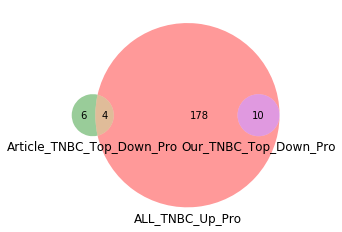

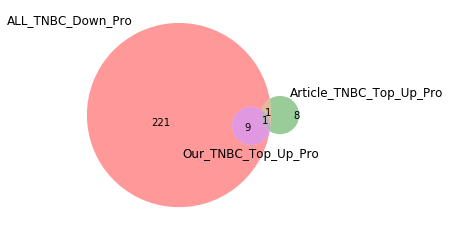

In [17]:
from matplotlib_venn import venn2, venn3

result = pd.read_csv('../include_top/TNBC_result.csv', sep=',')

def preprocess(s):
    return s.split('|')[-1]

TNBC_All = result['Protein'].tolist()

TNBC_Up = result[(result['log2FC'] > 1)&(result['pvalue'] < 0.05)]
TNBC_Down = result[(result['log2FC'] < -1)&(result['pvalue'] < 0.05)]
print("TNBC DownRegulated proteins: %d" %(len(set(TNBC_Down['Protein']))))
print("TNBC UpRegulated proteins: %d" %(len(set(TNBC_Up['Protein']))))

# ALL the differential changed proteins
ALL_TNBC_Up_Pro  = MapProtGeneName(list(map(preprocess, TNBC_Up['Protein'].tolist())))
ALL_TNBC_Down_Pro = MapProtGeneName(list(map(preprocess, TNBC_Down['Protein'].tolist())))

# The list of the top 10 most significant up- and downregulated proteins are given in the article.
Article_TNBC_Top_Down_Pro = ['FCGRT', 'ADH1B', 'SHMT1', 'STAB1', 'PLTP', 'DES', 'CFD', 'IGLV211', 'IGHG1', 'TNXB']
Article_TNBC_Top_Up_Pro = ['HMGA1', 'RREB1', 'THBS1', 'ESPN', 'HAT1', 'APC', 'FOXP4', 'GPRC5A', 'SNRNP27', 'STMN1']

# UpRegulated proteins top 10
Our_TNBC_Top_Up_Pro = MapProtGeneName(list(map(preprocess, TNBC_Up.sort_values(["log2FC"],ascending=False).head(10)['Protein'].tolist())))
print("The top 10 most significant upRegulated proteins: " + ",".join(Our_TNBC_Top_Up_Pro))

# top 10 downRegulated protein 
Our_TNBC_Top_Down_Pro = MapProtGeneName(list(map(preprocess, TNBC_Down.sort_values(["log2FC"],ascending=False).tail(10)['Protein'].tolist())))
print("The top 10 most significant downRegulated proteins: " + ",".join(Our_TNBC_Top_Down_Pro))

venn3(subsets=[set(ALL_TNBC_Down_Pro), set(Article_TNBC_Top_Down_Pro), set(Our_TNBC_Top_Down_Pro)], 
      set_labels=('ALL_TNBC_Up_Pro', 'Article_TNBC_Top_Down_Pro', 'Our_TNBC_Top_Down_Pro'))
plt.show()

venn3(subsets=[set(ALL_TNBC_Up_Pro), set(Article_TNBC_Top_Up_Pro), set(Our_TNBC_Top_Up_Pro)], 
      set_labels=('ALL_TNBC_Down_Pro', 'Article_TNBC_Top_Up_Pro', 'Our_TNBC_Top_Up_Pro'))
plt.show()


#### Volcano plots comparing MBC with TNBC and within MBC subtype (figure 3 B)

In [67]:
%%R -w 1000 -h 600

Within_Subtype_Comp<-matrix(c(-1,-1,0,0,1,1,1,0,-1,0,0,0,0,0,0),nrow=3)
row.names(Within_Subtype_Comp)<-c("SQUAMOUS vs SARCOMATOID", "SPINDLE vs SARCOMATOID", "SPINDLE vs SQUAMOUS")
colnames(Within_Subtype_Comp) = c("metaplastic breast carcinomas|Chondroid","metaplastic breast carcinomas|Spindle",
                        "metaplastic breast carcinomas|Squamous","Normal|Normal breast","Triple-negative breast cancer|Triple-negative")


Within_Subtype_Comp.pairwise <- groupComparisonTMT(quant_om.msstats, contrast.matrix = Within_Subtype_Comp, moderated = TRUE)

Within_Subtype_Comp['SQUAMOUS vs SARCOMATOID',]

INFO  [2021-08-05 09:28:01] Model fitting for 2876 proteins.
  |======================================================================| 100%
INFO  [2021-08-05 09:30:49] Testing for 2876 proteins:
  |======================================================================| 100%
      metaplastic breast carcinomas|Chondroid 
                                           -1 
        metaplastic breast carcinomas|Spindle 
                                            0 
       metaplastic breast carcinomas|Squamous 
                                            1 
                         Normal|Normal breast 
                                            0 
Triple-negative breast cancer|Triple-negative 
                                            0 


In [68]:
%%R

Within_Subtype_Comp = Within_Subtype_Comp.pairwise$ComparisonResult
write.table(Within_Subtype_Comp,"Within_Subtype_Comp_result.csv",row.names=FALSE,col.names=TRUE,sep=",")

                     Protein                    Label    log2FC    pvalue  \
0   sp|A0A075B6H7|KV37_HUMAN  SQUAMOUS vs SARCOMATOID  1.980219  0.127214   
1   sp|A0A075B6H7|KV37_HUMAN   SPINDLE vs SARCOMATOID  0.106951  0.942775   
2   sp|A0A075B6H7|KV37_HUMAN      SPINDLE vs SQUAMOUS -1.873268  0.227259   
3  sp|A0A075B6P5|KV228_HUMAN  SQUAMOUS vs SARCOMATOID  0.256941  0.708291   
4  sp|A0A075B6P5|KV228_HUMAN   SPINDLE vs SARCOMATOID -0.539817  0.386686   

   -Log10(p-value)    group  
0         0.895464  dimgrey  
1         0.025592  dimgrey  
2         0.643480  dimgrey  
3         0.149788  dimgrey  
4         0.412642  dimgrey  


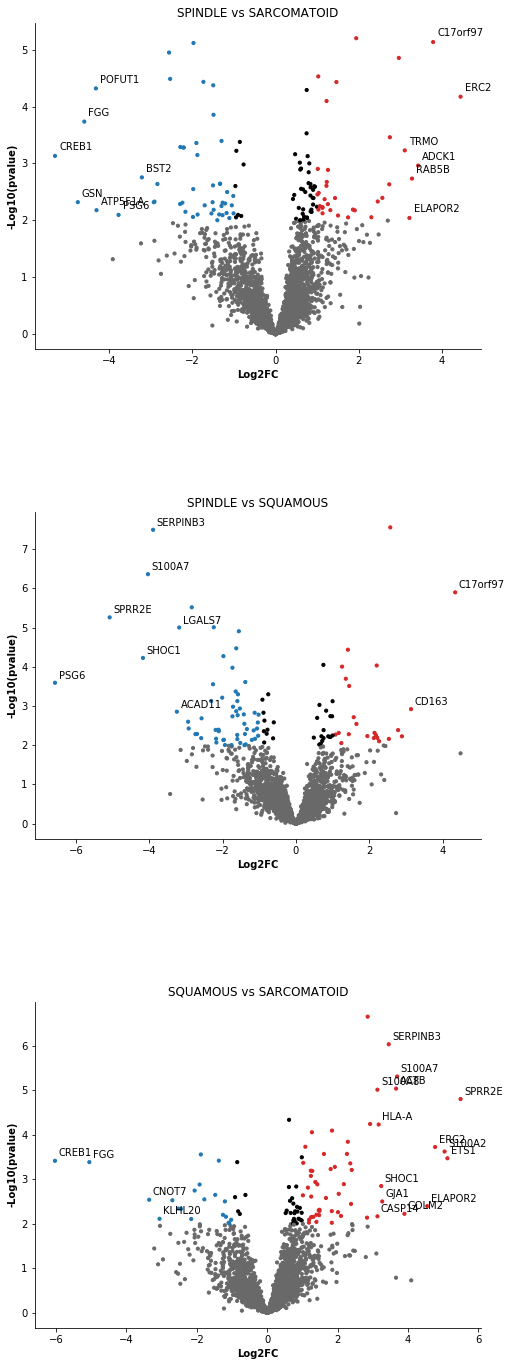

In [74]:
result = pd.read_csv('./Within_Subtype_Comp_result.csv', sep=',')
result = result[['Protein', 'Label', 'log2FC', 'pvalue']].dropna()
result["-Log10(p-value)"] = -np.log10(result['pvalue'])

#分组为up, normal, down
result['group'] = 'black'
result.loc[(result['log2FC'] > 1)&(result['pvalue'] < 0.01),'group'] = 'tab:red' 
result.loc[(result['log2FC'] < -1)&(result['pvalue'] < 0.01),'group'] = 'tab:blue'
result.loc[result['pvalue'] >= 0.01,'group'] = 'dimgrey'
print(result.head())


fig = plt.figure(figsize=(8, 24))
i = 1
for comp in np.unique(result['Label']):
    data = result[result['Label'] == comp]
    ax = fig.add_subplot(310 + i)
#     ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), title='')
    ax.scatter(data['log2FC'], data["-Log10(p-value)"], s=10, c=data['group'])
    ax.set_ylabel('-Log10(pvalue)',fontweight='bold')
    ax.set_xlabel('Log2FC',fontweight='bold')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
    
#     ax.vlines(-1, ymin, ymax, color='dimgrey',linestyle='dashed', linewidth=1) 
#     ax.vlines(1, ymin, ymax, color='dimgrey',linestyle='dashed', linewidth=1) 
#     ax.hlines(-np.log10(0.05), xmin, xmax, color='dimgrey',linestyle='dashed', linewidth=1)

#     ax.set_xticks(range(-2,2,1)) 
#     ax.set_yticks(range(-2,10,3)) 
    ax.set_title(comp)
    i += 1
    
    for _,row in data[(data['group'] != 'dimgrey')&(np.abs(data['log2FC']) > 3)].iterrows():
        ax.annotate(MapProtGeneName([preprocess(row['Protein'])])[0], xy = (row['log2FC'], row['-Log10(p-value)']), 
                    xytext = (row['log2FC']+0.1, row['-Log10(p-value)']+0.1))
    
plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.show()


In [86]:
%%R -w 800 -h 600

library('MSstatsTMT', warn.conflicts = F, quietly = T, verbose = F)
openms_output = './out_msstats_norm.csv'
raw.om <- read.csv(openms_output, header = TRUE, sep = '\t')

raw.om$Condition[which(raw.om$Condition == "metaplastic breast carcinomas|Chondroid"|raw.om$Condition=="metaplastic breast carcinomas|Spindle"|raw.om$Condition=="metaplastic breast carcinomas|Squamous")] <- "MBC"
input.om <- OpenMStoMSstatsTMTFormat(raw.om)

# use MSstatsTMT for protein summarization
quant_om.msstats <- proteinSummarization(input.om,
                                      method="msstats",
                                      global_norm=TRUE,
                                      reference_norm=TRUE,
                                      remove_norm_channel = TRUE,
                                      remove_empty_channel = TRUE)

print(levels(quant_om.msstats$ProteinLevelData$Condition))


INFO  [2021-08-05 13:51:46] ** Raw data from OpenMS imported successfully.
INFO  [2021-08-05 13:51:47] ** Raw data from OpenMS cleaned successfully.
INFO  [2021-08-05 13:51:47] ** The following options are used:
  - Features will be defined by the columns: PeptideSequence, PrecursorCharge
  - Shared peptides will be removed.
  - Proteins with single feature will not be removed.
  - Features with less than 3 measurements within each run will be removed.
INFO  [2021-08-05 13:51:47] ** Features with all missing measurements across channels within each run are removed.
INFO  [2021-08-05 13:51:47] ** Shared peptides are removed.
INFO  [2021-08-05 13:51:47] ** Features with one or two measurements across channels within each run are removed.
INFO  [2021-08-05 13:51:54] ** PSMs have been aggregated to peptide ions.
INFO  [2021-08-05 13:51:56] ** Fractions belonging to same mixture have been combined.
INFO  [2021-08-05 13:51:56] ** Features with one or two measurements across channels within e

In [90]:
%%R

MBC_TNBC_Comp<-matrix(c(1,0,-1),nrow=1)
row.names(MBC_TNBC_Comp)<-c("MBC vs TNBC")
colnames(MBC_TNBC_Comp) = c("MBC","Normal|Normal breast", "Triple-negative breast cancer|Triple-negative")


MBC_TNBC_Comp.pairwise <- groupComparisonTMT(quant_om.msstats, contrast.matrix = MBC_TNBC_Comp, moderated = TRUE)
MBC_TNBC_Comp = MBC_TNBC_Comp.pairwise$ComparisonResult
write.table(MBC_TNBC_Comp,"MBC_TNBC_Comp_result.csv",row.names=FALSE,col.names=TRUE,sep=",")

INFO  [2021-08-05 14:04:55] Model fitting for 2876 proteins.
  |======================================================================| 100%
INFO  [2021-08-05 14:07:31] Testing for 2876 proteins:
  |======================================================================| 100%


                     Protein        Label    log2FC    pvalue  \
0   sp|A0A075B6H7|KV37_HUMAN  MBC vs TNBC -0.009539  0.992943   
1  sp|A0A075B6P5|KV228_HUMAN  MBC vs TNBC  0.674330  0.176702   
2  sp|A0A087WSY6|KVD15_HUMAN  MBC vs TNBC  0.723556  0.069627   
3  sp|A0A0A0MT36|KVD21_HUMAN  MBC vs TNBC  1.788936  0.167944   
4  sp|A0A0B4J1V0|HV315_HUMAN  MBC vs TNBC  0.611270  0.065259   

   -Log10(p-value)    group  
0         0.003076  dimgrey  
1         0.752758  dimgrey  
2         1.157223  dimgrey  
3         0.774835  dimgrey  
4         1.185359  dimgrey  


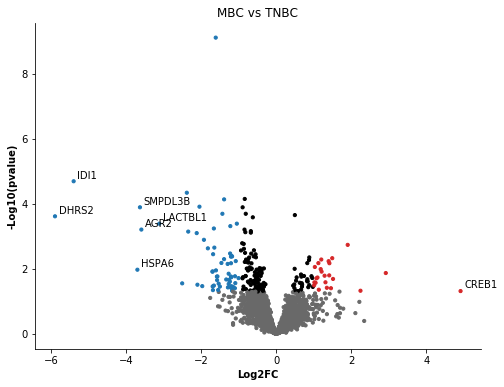

In [94]:
result = pd.read_csv('./MBC_TNBC_Comp_result.csv', sep=',')
result = result[['Protein', 'Label', 'log2FC', 'pvalue']].dropna()
result["-Log10(p-value)"] = -np.log10(result['pvalue'])

#up, normal, down
result['group'] = 'black'
result.loc[(result['log2FC'] > 1)&(result['pvalue'] < 0.05),'group'] = 'tab:red' 
result.loc[(result['log2FC'] < -1)&(result['pvalue'] < 0.05),'group'] = 'tab:blue'
result.loc[result['pvalue'] >= 0.05,'group'] = 'dimgrey'
print(result.head())


fig = plt.figure(figsize=(8, 6))
i = 1
for comp in np.unique(result['Label']):
    data = result[result['Label'] == comp]
    ax = fig.add_subplot(110 + i)
#     ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), title='')
    ax.scatter(data['log2FC'], data["-Log10(p-value)"], s=10, c=data['group'])
    ax.set_ylabel('-Log10(pvalue)',fontweight='bold')
    ax.set_xlabel('Log2FC',fontweight='bold')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
    
#     ax.vlines(-1, ymin, ymax, color='dimgrey',linestyle='dashed', linewidth=1) 
#     ax.vlines(1, ymin, ymax, color='dimgrey',linestyle='dashed', linewidth=1) 
#     ax.hlines(-np.log10(0.05), xmin, xmax, color='dimgrey',linestyle='dashed', linewidth=1)

#     ax.set_xticks(range(-2,2,1)) 
#     ax.set_yticks(range(-2,10,3)) 
    ax.set_title(comp)
    i += 1
    
    for _,row in data[(data['group'] != 'dimgrey')&(np.abs(data['log2FC']) > 3)].iterrows():
        ax.annotate(MapProtGeneName([preprocess(row['Protein'])])[0], xy = (row['log2FC'], row['-Log10(p-value)']), 
                    xytext = (row['log2FC']+0.1, row['-Log10(p-value)']+0.1))
    
plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.show()


### Vislization MBC subtype vs TNBC (Supplementary Figure 7)

In [95]:
%%R

openms_output = './out_msstats_norm.csv'
raw.om <- read.csv(openms_output, header = TRUE, sep = '\t')
input.om <- OpenMStoMSstatsTMTFormat(raw.om)

# use MSstatsTMT for protein summarization
quant_om.msstats <- proteinSummarization(input.om,
                                      method="msstats",
                                      global_norm=TRUE,
                                      reference_norm=TRUE,
                                      remove_norm_channel = TRUE,
                                      remove_empty_channel = TRUE)


levels(quant_om.msstats$ProteinLevelData$Condition)

INFO  [2021-08-05 14:30:08] ** Raw data from OpenMS imported successfully.
INFO  [2021-08-05 14:30:09] ** Raw data from OpenMS cleaned successfully.
INFO  [2021-08-05 14:30:09] ** The following options are used:
  - Features will be defined by the columns: PeptideSequence, PrecursorCharge
  - Shared peptides will be removed.
  - Proteins with single feature will not be removed.
  - Features with less than 3 measurements within each run will be removed.
INFO  [2021-08-05 14:30:09] ** Features with all missing measurements across channels within each run are removed.
INFO  [2021-08-05 14:30:09] ** Shared peptides are removed.
INFO  [2021-08-05 14:30:09] ** Features with one or two measurements across channels within each run are removed.
INFO  [2021-08-05 14:30:16] ** PSMs have been aggregated to peptide ions.
INFO  [2021-08-05 14:30:17] ** Fractions belonging to same mixture have been combined.
INFO  [2021-08-05 14:30:17] ** Features with one or two measurements across channels within e

In [96]:
%%R
Subtype_TNBC_Comp<-matrix(c(0,0,1,1,0,0,0,1,0,0,0,0,-1,-1,-1),nrow=3)
row.names(Subtype_TNBC_Comp)<-c("Spindle vs TNBC", "Squamous vs TNBC", "Sarcomatoid vs TNBC")
colnames(Subtype_TNBC_Comp) = c("metaplastic breast carcinomas|Chondroid","metaplastic breast carcinomas|Spindle",
                        "metaplastic breast carcinomas|Squamous","Normal|Normal breast","Triple-negative breast cancer|Triple-negative")


Subtype_TNBC_Comp.pairwise <- groupComparisonTMT(quant_om.msstats, contrast.matrix = Subtype_TNBC_Comp, moderated = TRUE)

print(Subtype_TNBC_Comp)

Subtype_TNBC_Comp = Subtype_TNBC_Comp.pairwise$ComparisonResult
write.table(Subtype_TNBC_Comp,"Subtype_TNBC_Comp_result.csv",row.names=FALSE,col.names=TRUE,sep=",")

INFO  [2021-08-05 14:36:16] Model fitting for 2876 proteins.
  |======================================================================| 100%
INFO  [2021-08-05 14:39:01] Testing for 2876 proteins:
  |======================================================================| 100%
                    metaplastic breast carcinomas|Chondroid
Spindle vs TNBC                                           0
Squamous vs TNBC                                          0
Sarcomatoid vs TNBC                                       1
                    metaplastic breast carcinomas|Spindle
Spindle vs TNBC                                         1
Squamous vs TNBC                                        0
Sarcomatoid vs TNBC                                     0
                    metaplastic breast carcinomas|Squamous Normal|Normal breast
Spindle vs TNBC                                          0                    0
Squamous vs TNBC                                         1                    0
Sarcomatoid 

['LACTBL1', 'RNASET2', 'ERC2', 'AGR2', 'HSPA6', 'RAB5B', 'PSG6', 'NCBP1', 'IDI1', 'ADCK1', 'NLRP1', 'POFUT1', 'CNOT7', 'GSN', 'CREB1', 'FGG', 'CNN3', 'CP', 'SMPDL3B', 'ATP5F1A']
['LACTBL1', 'AGR2', 'HSPA6', 'DHRS2', 'IDI1', 'TADA2B', 'CREB1', 'SMPDL3B', 'C17orf97']
['SPRR2E', 'S100A2', 'SERPINB3', 'S100A7', 'LGALS7', 'LGALS7B', 'MRPS5', 'PSG6', 'DHRS2', 'IDI1', 'SHOC1', 'ACTB', 'ACAD11']


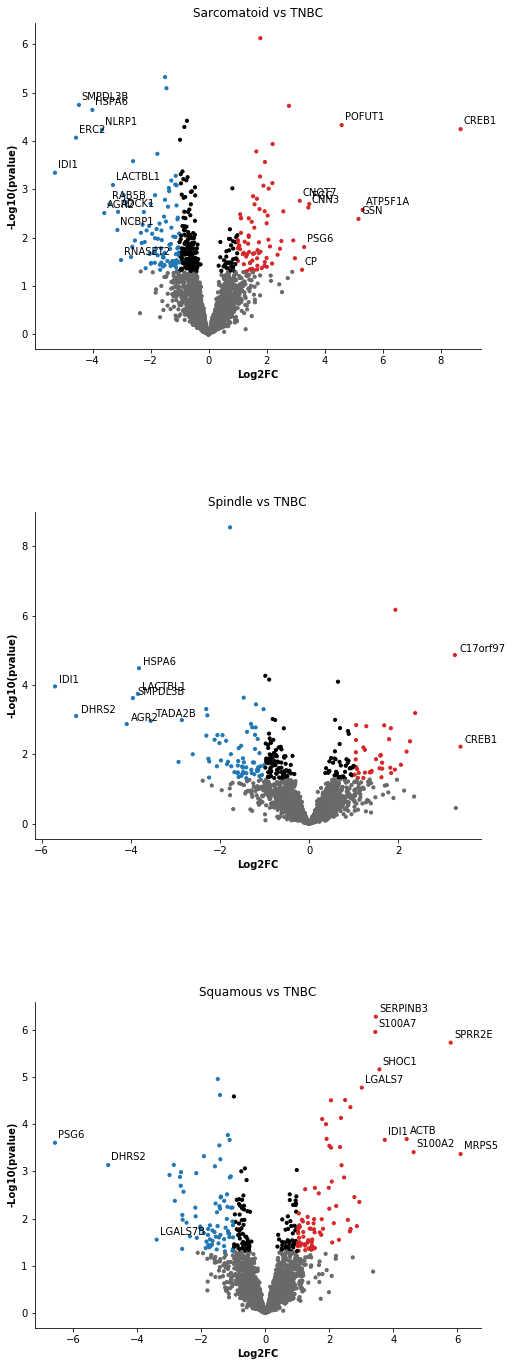

In [108]:
result = pd.read_csv('./Subtype_TNBC_Comp_result.csv', sep=',')
result = result[['Protein', 'Label', 'log2FC', 'pvalue']].dropna()
result["-Log10(p-value)"] = -np.log10(result['pvalue'])

#up, normal, down
result['group'] = 'black'
result.loc[(result['log2FC'] > 1)&(result['pvalue'] < 0.05),'group'] = 'tab:red' 
result.loc[(result['log2FC'] < -1)&(result['pvalue'] < 0.05),'group'] = 'tab:blue'
result.loc[result['pvalue'] >= 0.05,'group'] = 'dimgrey'


fig = plt.figure(figsize=(8, 24))
i = 1
for comp in np.unique(result['Label']):
    data = result[result['Label'] == comp]
    ax = fig.add_subplot(310 + i)
#     ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), title='')
    ax.scatter(data['log2FC'], data["-Log10(p-value)"], s=10, c=data['group'])
    ax.set_ylabel('-Log10(pvalue)',fontweight='bold')
    ax.set_xlabel('Log2FC',fontweight='bold')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
    
#     ax.vlines(-1, ymin, ymax, color='dimgrey',linestyle='dashed', linewidth=1) 
#     ax.vlines(1, ymin, ymax, color='dimgrey',linestyle='dashed', linewidth=1) 
#     ax.hlines(-np.log10(0.05), xmin, xmax, color='dimgrey',linestyle='dashed', linewidth=1)

#     ax.set_xticks(range(-2,2,1)) 
#     ax.set_yticks(range(-2,10,3)) 
    ax.set_title(comp)
    i += 1
    
    g = MapProtGeneName(list(map(preprocess, data[(data['group'] != 'dimgrey')&(np.abs(data['log2FC']) > 3)]['Protein'].tolist())))
    j = 0
    print(g)
    for _, row in data[(data['group'] != 'dimgrey')&(np.abs(data['log2FC']) > 3)].iterrows():
        ax.annotate(g[j], xy = (row['log2FC'], row['-Log10(p-value)']), 
                    xytext = (row['log2FC']+0.1, row['-Log10(p-value)']+0.1))
        j += 1
    
plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.show()


###  Protein expression Heatmaps

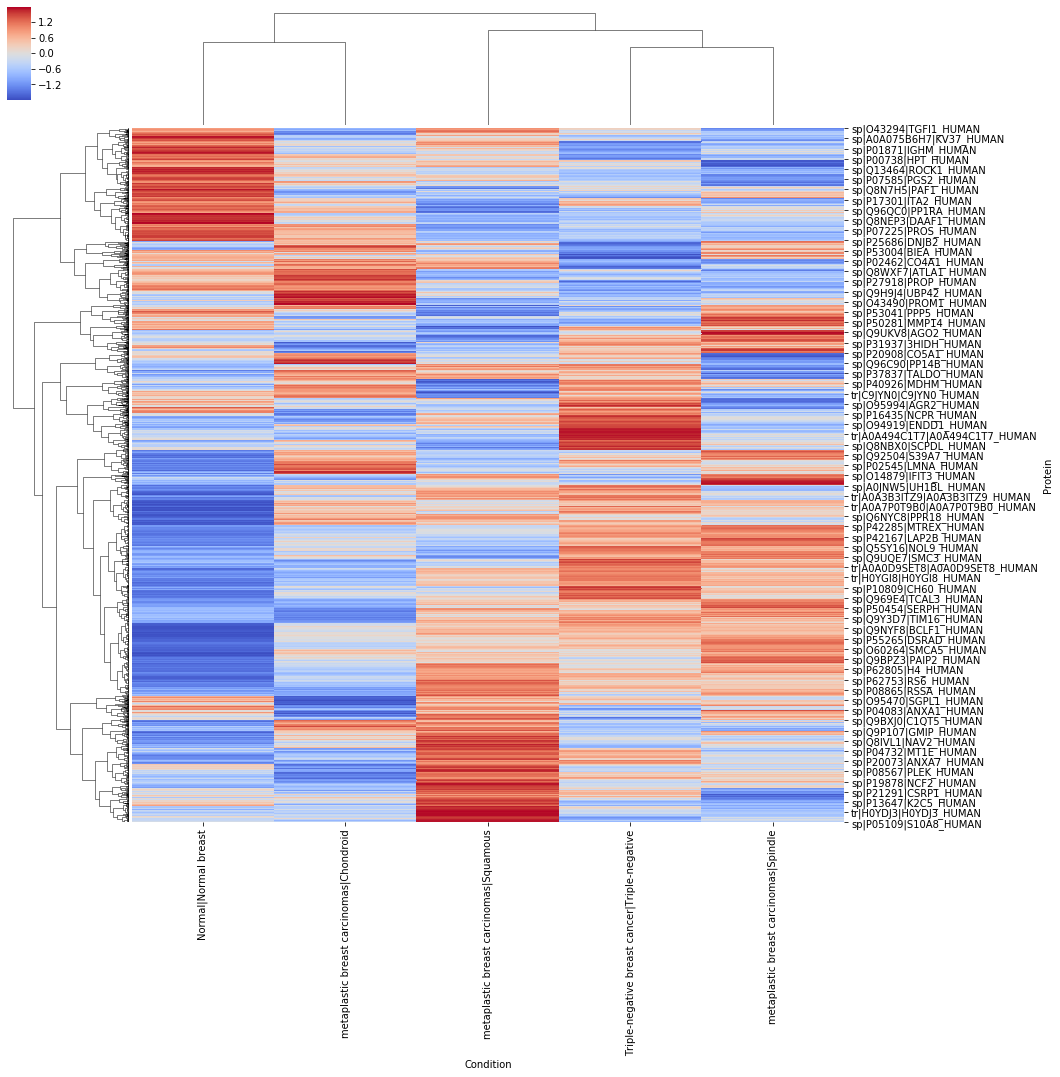

In [18]:
# Libraries
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
 
# Data set
url = './protein_expression.csv'
df = pd.read_csv(url)

df2 = df.pivot_table(index='Protein', columns='Condition', values='Abundance',aggfunc=np.mean)
df2 = df2.dropna()

# plot
g = sns.clustermap(df2, method='average', metric='correlation', z_score=0, figsize=(15,15), xticklabels=True, cmap="coolwarm")
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels())#, fontsize = 5)

# tmp = g.ax_heatmap.get_xaxis()

threshold = 0.1
x_labels_ticks = g.ax_heatmap.get_xticklabels()

total_genes_above_threshold = 0
for i, xtickdata in enumerate(x_labels_ticks):
    protein = xtickdata._text
    if df2[protein].max() >= threshold:
        # print(df2[protein])
        # print("#########")
        total_genes_above_threshold = total_genes_above_threshold + 1
        # print(df2[protein].max())
    else:
        xtickdata._text = ''

#print("total_genes_above_threshold {}".format(total_genes_above_threshold))

# re set the tick labels with the modified list
g.ax_heatmap.set_xticklabels(x_labels_ticks)
plt.show()